In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision 
from torch import nn
from torch import optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
from utils import Utility
from PIL import Image, ImageOps
import random
from sklearn import metrics
from typing import Callable, Dict, List, Tuple, Union
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_images, train_data = Utility.read_dataset("train","2020")
val_images, val_data = Utility.read_dataset("val","2020")

train data size= 4000
val data size= 500


In [4]:
train_data['question_parsed'], train_data['answer_parsed'] = Utility.clean(train_data)
val_data['question_parsed'], val_data['answer_parsed'] = Utility.clean(val_data)

train_data.sample(5)

,image_name,question,answer,question_parsed,answer_parsed
3368,synpic32355,what abnormality is seen in the image?,renal cell carcinoma,what abnormality is seen in the image ?,renal cell carcinoma
257,synpic50957,what is most alarming about this ct scan?,pancreatic adenocarcinoma,what is most alarming about this ct ?,pancreatic adenocarcinoma
1647,synpic15730,what is the primary abnormality in this image?,killian-jamieson diverticulum,what is the primary abnormality in this image ?,killian jamieson diverticulum
628,synpic20101,what is most alarming about this x-ray?,radial head fracture,what is most alarming about this x ray ?,radial head fracture
160,synpic55765,what abnormality is seen in the image?,enlarged subarachnoid space,what abnormality is seen in the image ?,enlarged subarachnoid space


In [5]:
train_data['image_name'] = '/.............../Data/train_2020/Train_images/'+train_data['image_name']+'.jpg' #Update
val_data['image_name'] = '/................../Data/val_2020/Val_images/'+val_data['image_name']+'.jpg' #Update

train_data.head()

,image_name,question,answer,question_parsed,answer_parsed
0,/home/numansaeed/Documents/ML_Project (Don't D...,is this a normal gastrointestinal image?,yes,is this a normal gastrointestinal image ?,yes
1,/home/numansaeed/Documents/ML_Project (Don't D...,is the x-ray normal?,yes,is the x ray normal ?,yes
2,/home/numansaeed/Documents/ML_Project (Don't D...,is this image normal?,yes,is this image normal ?,yes
3,/home/numansaeed/Documents/ML_Project (Don't D...,is there an abnormality in the x-ray?,no,is there an abnormality in the x ray ?,no
4,/home/numansaeed/Documents/ML_Project (Don't D...,is there evidence of any abnormalities?,no,is there evidence of any abnormalities ?,no


In [6]:
class_names = sorted(list(set(train_data['answer_parsed'])))
print(sorted(class_names)[:10])

['abdominal abscess', 'abdominal aortic aneurysm', 'abdominal compartment syndrome', 'aberrant right subclavian artery arsa', 'achalasia', 'achilles tendon rupture', 'acl injury', 'acute appendicitis', 'acute calculous cholecystitis', 'acute mesenteric ischemia']


In [7]:
class_dict = { i : class_names[i] for i in range(0, len(class_names) ) }
class_dict = {y:x for x,y in class_dict.items()}

#print(class_dict)

In [8]:
class_dict['fibromatosis coli']

117

In [9]:
class_names_val = sorted(list(set(val_data['answer_parsed'])))
print(len(class_names_val))

232


In [10]:
class MedVQA(torch.utils.data.Dataset):
    def __init__(self, mode, data, class_dict, class_names_val,transform = None):
        def get_images(data, class_name):
                temp_df = data[data['answer_parsed'] == class_name]
                images = [x for x in temp_df['image_name']]
                #print(f'Found {len(images)} {class_name} examples')
                return images
            
        self.df = data
        self.class_names = list(class_dict.keys())
        self.class_names_val=class_names_val
        self.mode= mode
        self.class_dict=class_dict
        #print(self.class_names)
        self.images = {}

        if self.mode == 'train':
            
              for class_name in self.class_names:
                self.images[class_name] = get_images(data, class_name)
        else:
              for class_name in self.class_names_val:
                self.images[class_name] = get_images(data, class_name)

        self.transform = transform    

    def __getitem__(self, index):
        
        if self.mode == 'train':
            class_name = random.choice(self.class_names)
        else:
            class_name = random.choice(self.class_names_val)  

        index = index % len(self.images[class_name])
        image_path = self.images[class_name][index]
        image = Image.open(image_path).convert('RGB')
        question = self.df[self.df['image_name']==image_path]['question_parsed'].values
        answer = self.df[self.df['image_name']==image_path]['answer_parsed'].values
        #label = self.class_names.index(class_name)
        label = self.class_dict[class_name]
        if self.transform:
            image = self.transform(image)

        return image, question[0], answer[0], label

    def __len__(self):
        return len(self.df)

In [11]:
class XRayTransform:
    """XRayTransform base class."""

    def __repr__(self):
        return "XRayTransform: {}".format(self.__class__.__name__)

class HistogramNormalize(XRayTransform):
    """
    Apply histogram normalization.
    Args:
        number_bins: Number of bins to use in histogram.
    """

    def __init__(self, number_bins: int = 256):
        self.number_bins = number_bins

    def __call__(self, sample: Dict) -> Dict:
        image = sample.numpy()

        # get image histogram
        image_histogram, bins = np.histogram(
            image.flatten(), self.number_bins, density=True
        )
        cdf = image_histogram.cumsum()  # cumulative distribution function
        cdf = 255 * cdf / cdf[-1]  # normalize

        # use linear interpolation of cdf to find new pixel values
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
        image_equalized.reshape(image.shape)

        sample = torch.tensor(image_equalized.reshape(image.shape)).to(
            sample
        )

        return sample

class TensorToRGB(XRayTransform):
    """
    Convert Tensor to RGB by replicating channels.
    Args:
        num_output_channels: Number of output channels (3 for RGB).
    """

    def __init__(self, num_output_channels: int = 3):
        self.num_output_channels = num_output_channels

    def __call__(self, sample: Dict) -> Dict:
        expands = list()
        for i in range(sample.ndim):
            if i == 0:
                expands.append(self.num_output_channels)
            else:
                expands.append(-1)
        sample = sample.expand(*expands)

        return sample

In [12]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(size=(224,224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.RandomRotation(degrees=10),
                                 transforms.ToTensor(),
#                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
                                 transforms.Normalize(mean=[0.2577, 0.2578, 0.2578],
                                 std=[0.2206, 0.2206, 0.2205]),
                                 #HistogramNormalize(),
                                 #TensorToRGB()

    ]),
    'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225]),
                                transforms.Normalize(mean=[0.2577, 0.2578, 0.2578],
                                 std=[0.2206, 0.2206, 0.2205]),
                                #HistogramNormalize(),
                                #TensorToRGB()    
    ])

}
train_dataset = MedVQA('train', train_data, class_dict, class_names_val, data_transforms['train'])
test_dataset = MedVQA('val', val_data, class_dict,  class_names_val, data_transforms['test'])

In [13]:
batch_size = 16

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 250
Number of test batches 32


In [14]:
class_names = list(class_dict.keys())

def show_images(images,questions, labels, preds):
    plt.figure(figsize=(15,12))
    for i, image in enumerate(images):
        plt.subplot(2, 3, i + 1, xticks=[], yticks=[])
        image = (image.numpy()).transpose((1, 2, 0))
        mean = np.array([0.2577, 0.2578, 0.2578])
        std = np.array([0.2206, 0.2206, 0.2205])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.title(f'{questions[i]}', fontsize = 10)
        plt.xlabel(f'{labels[i]}', fontsize = 10)
        plt.ylabel(f'{preds[i]}', color = col, fontsize = 10)
        
    plt.tight_layout()
    plt.show()

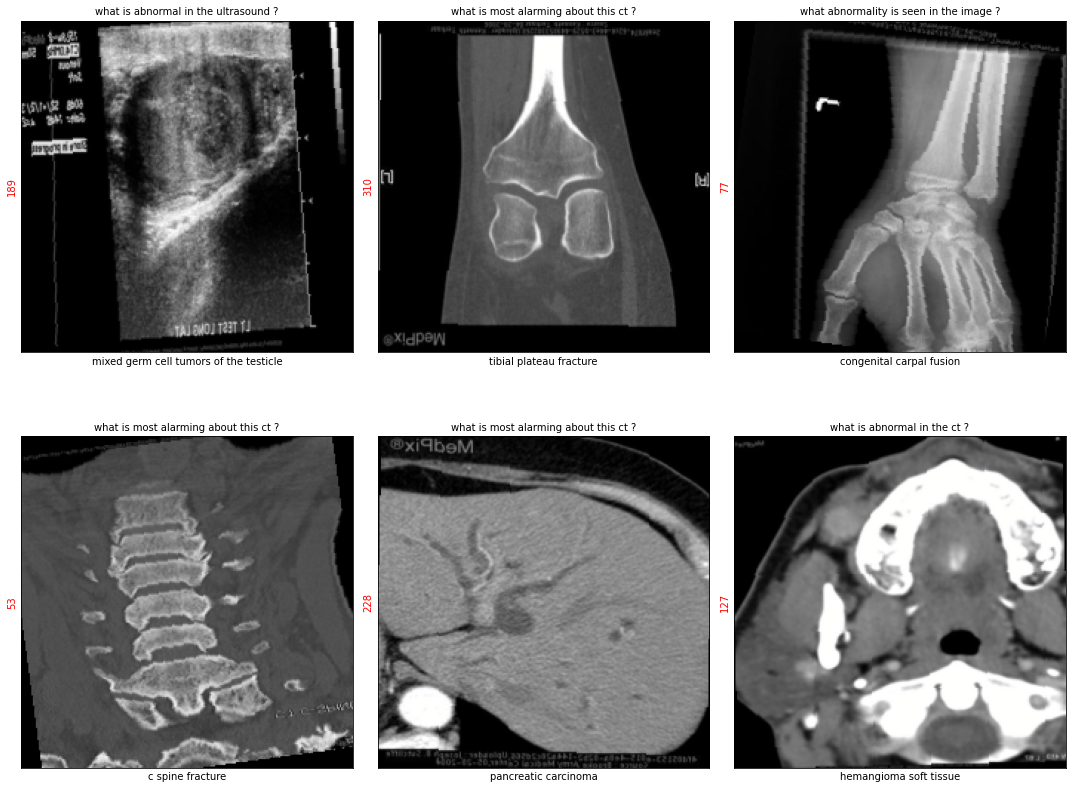

In [15]:
images, questions, answers, labels = next(iter(dl_train))
show_images(images[:6], questions, answers, labels)

In [ ]:
class ResNetModelSSL(nn.Module):

    def __init__(self, path):
        """
        Pass in parsed HyperOptArgumentParser to the model
        :param hparams:
        """
        super().__init__()

        pretrained_dict = torch.load(path)["state_dict"]

        state_dict = {}
        for k, v in pretrained_dict.items():
            if k.startswith("model.network."):
                k = k.replace("model.network.", "")
                state_dict[k] = v

        self.resnet = models.resnet50()
        del self.resnet.fc

        self.resnet.load_state_dict(state_dict)

        self.resnet.fc =  nn.Sequential(
            nn.Linear(2048, 332),
            )


    def forward(self, x):
        logits = self.resnet(x)

        return logits

In [ ]:
model = ResNetModelSSL('resnet50_pretrained.ckpt')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model.resnet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15)

In [ ]:
def show_preds():
    model.eval()
    images,questions,_ ,labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    
    images = images.to('cpu')
    labels = labels.to('cpu')
    _, preds = torch.max(outputs, 1)
    show_images(images[:6], questions, labels, preds)

In [ ]:
best_model = model

def train(epochs):
    print('Starting training..')
    best_accuracy = 0
    for e in range(0, epochs):
        print('='*16)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*16)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, questions,_, labels) in enumerate(dl_train):


            images = images.to(device)
            labels = labels.to(device)
          
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()
            train_loss += loss.item()
            if train_step % 16 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0
                
                with torch.no_grad():
                    

                    model.eval() # set model to eval phase

                    for val_step, (images, question, _,  labels) in enumerate(dl_test):

                        images = images.to(device)
                        labels = labels.to(device)

                        outputs = model(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()

                        _, preds = torch.max(outputs, 1)
                        
                        accuracy += sum((preds == labels))

                    val_loss /= (val_step + 1)
                    accuracy = accuracy/len(test_dataset)
                    if (accuracy > best_accuracy):
                        best_model=model
                        best_accuracy = accuracy
                    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')


                model.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
%%time

train(epochs=50)

In [ ]:
model = best_model
model = model.to('cpu')
model.eval() # set model to eval phase
y_true=[]
y_pred=[]
for val_step, (images, question, _,  labels) in enumerate(dl_test):


    outputs = model(images)

    y_true.append(labels)
    y_pred.append(outputs)

In [ ]:
num_classes=332
Y_true=torch.cat((torch.flatten(torch.stack(y_true[:-1])),y_true[-1]),dim=0)
Y_pred=torch.stack(y_pred[:-1])
Y_pred=torch.reshape(torch.stack(y_pred[:-1]),(Y_pred.shape[0]*Y_pred.shape[1],num_classes))
Y_pred=torch.cat((Y_pred,y_pred[-1]),dim=0)
Y_prob=Y_pred
_, Y_pred = torch.max(Y_pred, 1)
Y_true=Y_true.to('cpu')
Y_pred=Y_pred.to('cpu')
Y_prob=Y_prob.to('cpu')

Y_true=Y_true.numpy()
Y_pred=Y_pred.numpy()
Y_prob=Y_prob.detach().numpy()
Y_prob=tf.nn.softmax(Y_prob)
Y_true_oh=tf.keras.utils.to_categorical(Y_true, num_classes=332)
print('Y_true:', Y_true.shape)
print(Y_pred.shape)
print(Y_prob.shape)
print(Y_true_oh.shape)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)

In [ ]:
multiclass_roc_auc_score(Y_true, Y_pred)

In [ ]:
acc=np.mean(Y_true==Y_pred)
F1=metrics.f1_score(Y_true, Y_pred, average='weighted')

print('F1 Score:', F1)
print('Accuracy: ', acc)